This notebook visualizes simulated data generated by `sim_counts.R`, which generates data to be used with GLiMMIRS-base.

In [1]:
library(rhdf5)
library(dplyr)
library(tidyr)
library(ggplot2)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# set the plot sizes to be full width
library(repr)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

# Load 
Load h5 file outputted by `sim_counts.R` script.

This data was generated using default settings:
- 13000 genes
- 50000 cells
- 1000 genes with targeted enhancers
- 2 gRNAs per target site
- $\lambda=15$ represents simulated MOI

In [ ]:
# # set wd to GLiMMIRS/
# setwd("../../")

In [3]:
# h5.path = "/iblm/netapp/data1/jezhou/crisprQTL/sim_base_data/sim.h5"
# h5.path = "data/simulated/sim_data_base"
h5ls(h5.path)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_GROUP,,
2,/counts,counts,H5I_DATASET,INTEGER,13000 x 50000
3,/,guides,H5I_GROUP,,
4,/guides,metadata,H5I_DATASET,COMPOUND,2000
5,/guides,noisy_guide_efficiencies,H5I_DATASET,COMPOUND,2000
6,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 2000
7,/,linear_predictor,H5I_GROUP,,
8,/linear_predictor,linear_predictor,H5I_DATASET,FLOAT,13000 x 50000


Let's walk through the structure of the h5 file:

- `/coeffs` stores a dataframe containing all of the ground truth coefficients used the define the negative binomial distribution from which counts were sampled for each gene
- `/counts/counts` stores a matrix containing the simulated counts for each gene x cell
- `/guides/metadata` stores a dataframe containing metadata (target gene identifier, gRNA efficiency, effect size of target site perturbation on the target gene) for all gRNAs in the simulated experiment, with each row index corresponding to a gRNA identifier (e.g. row 1 contains data for gRNA 1)
- `/guides/noisy_guide_efficiencies` will be present if you simulated data with noisy efficiencies. It is a data frame where each gRNA identifier and its true efficiency is recorded alongside its noisy counterpart for each value of $D$ specified to `sim_counts.R`
- `/guides/one_hot` stores a matrix one-hot encoding of which gRNAs (column index = gRNA identifier) are found in which cells (row index = cell identifier)
- `/linear_predictor/linear_predictor` stores the value of the linear predictor calculated for each gene (row) and cell (column)
<!-- - `/mu/mu` stores the value of $\mu$ (exponentiated form of the linear predictor) for each gene (row) and cell (column) -->
- `/scaling_factors` stores the simulated scaling factors ($s$) for every cell in the simulated experiment
- `/x/cell_cycle_scores` is a data frame containing the simulated S and G2M cell cycle scores for each cell in the simulated experiment
- `/x/percent_mito` stores the simulated percentage of mitochondrila DNA in each cell in the simulated experiment
- `/x/perturbation_prob` stores the perturbation probability of each gene's (row index) enhancer in each cell, calculated from the efficiencies of the gRNAs targeting the given enhancer present in each cell

# gRNA metadata

Get a table of every gRNA in the simulated "guide library" and their target genes. The row index is equivalent to the gRNA identifier, and the number of rows in this table is equivalent to the tutoal number of gRNAs in the simulated library.

In [4]:
guide.metadata <- h5read(h5.path, "guides/metadata")
head(guide.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,9888,0.6453288,-2.395420
2,7985,0.7626376,-2.539557
3,8110,0.8453918,-1.708152
4,9734,0.4590749,-1.586821
5,1708,0.8424424,-1.418216
6,661,0.6880075,-1.674249


In [5]:
print(paste("Enhancers of", length(unique(guide.metadata$target.gene)), "genes are targeted in this experiment"))
print(paste(nrow(guide.metadata)/length(unique(guide.metadata$target.gene)), "gRNAs targeting each site"))

[1] "Enhancers of 1000 genes are targeted in this experiment"
[1] "2 gRNAs targeting each site"


Visualize distribution of gRNA effect sizes and efficiencies.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



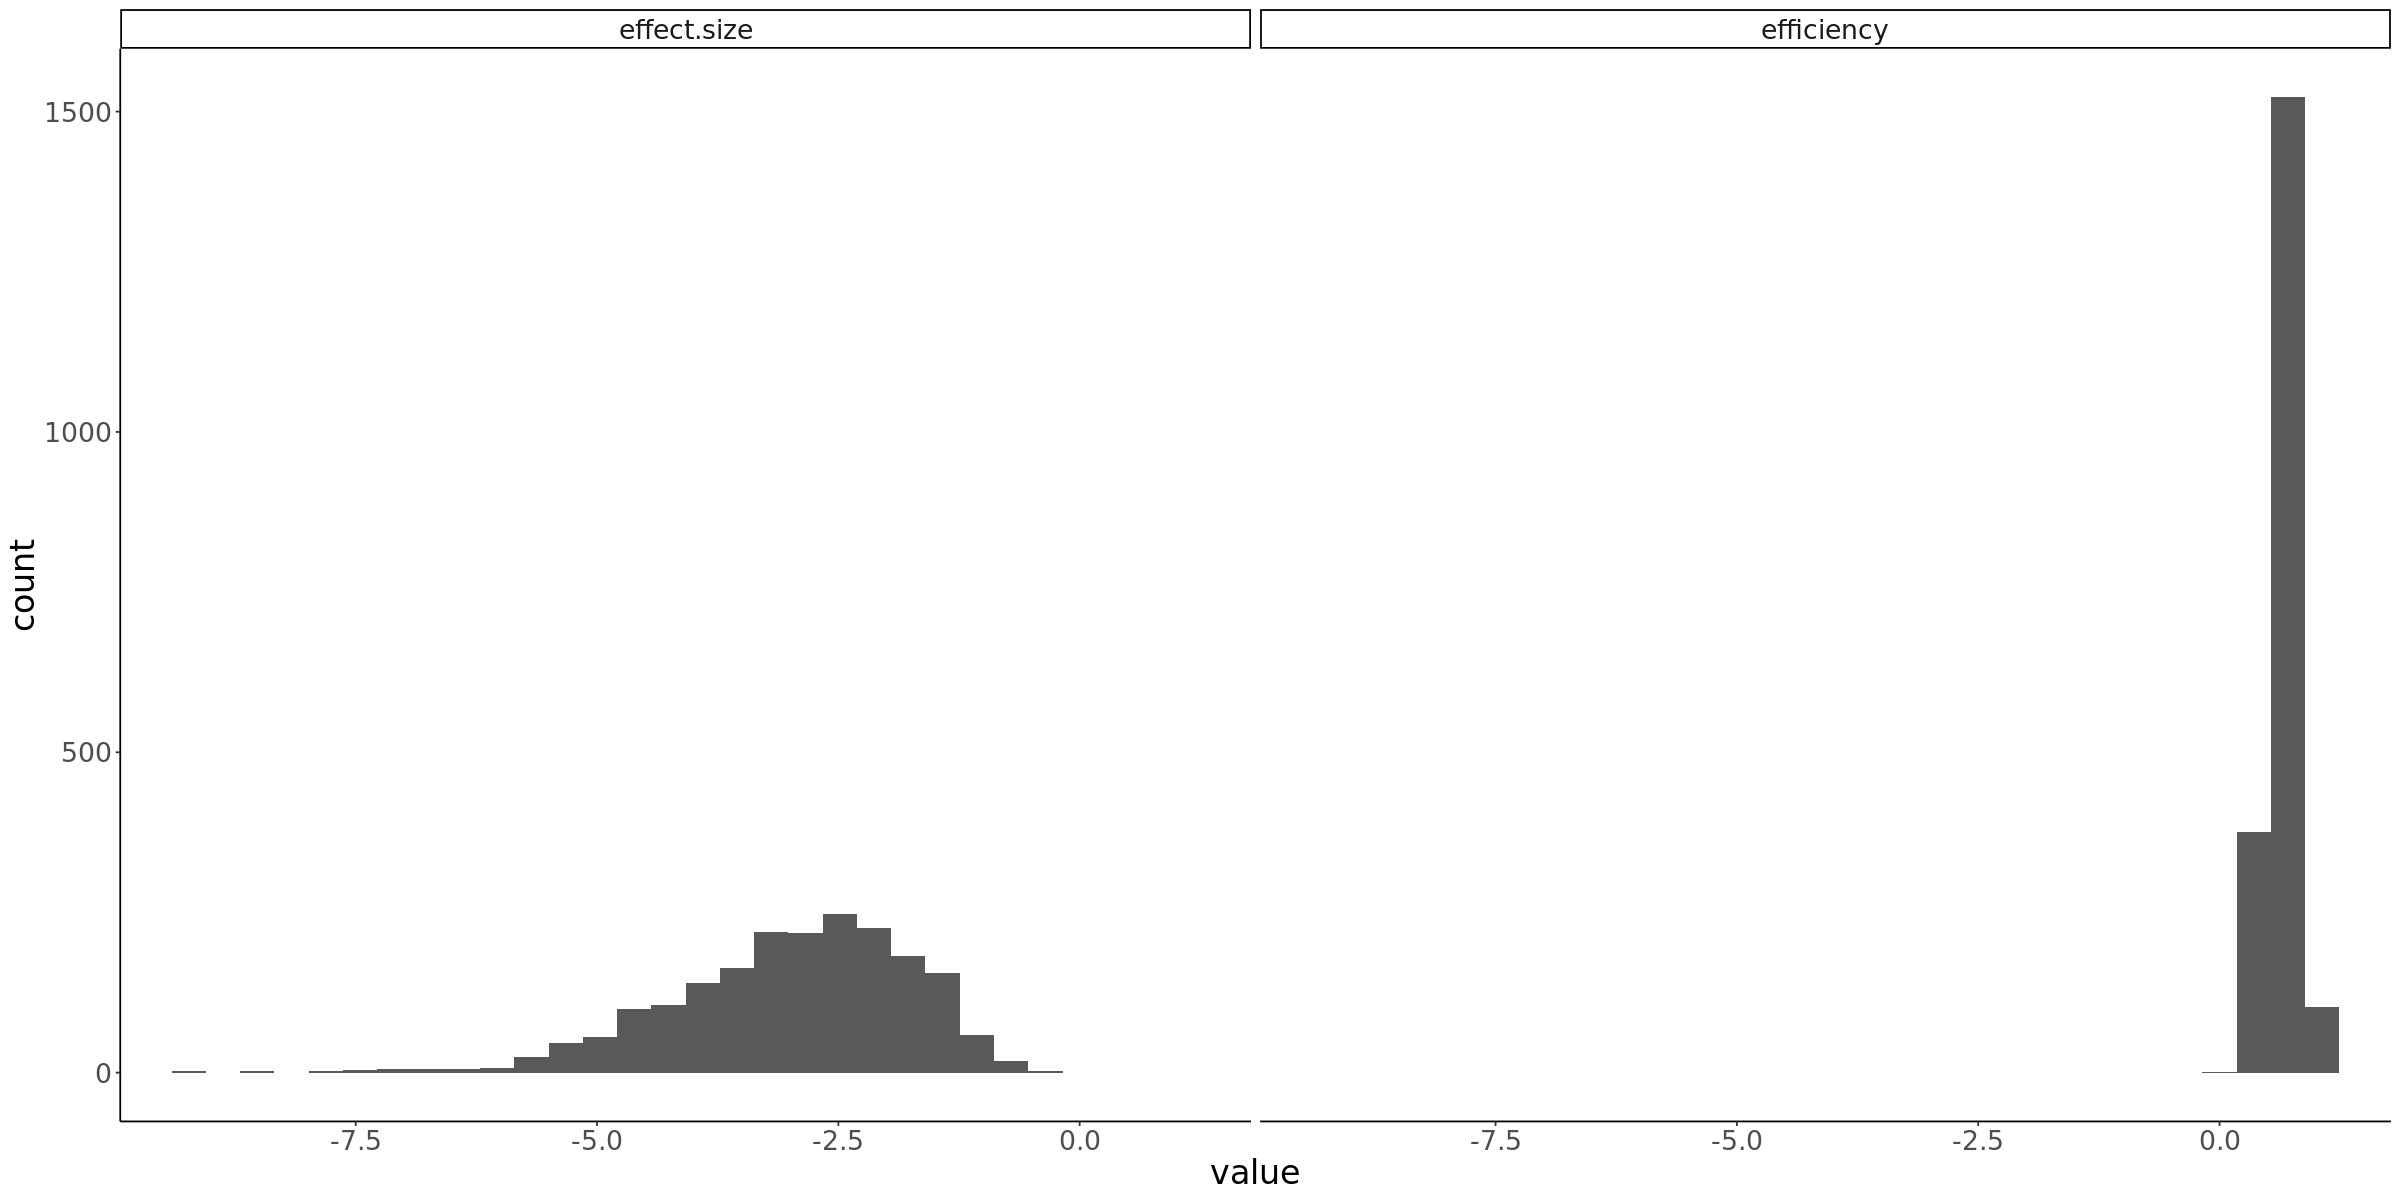

In [6]:
grna.plotdf <- guide.metadata %>% pivot_longer(cols = -target.gene, names_to = "metric")
ggplot(grna.plotdf, aes(x = value)) + geom_histogram() + 
            facet_wrap(~metric) + theme_classic() + theme(text = element_text(size = 20))

We also wrote a one-hot encoding of which gRNAs are found in which cells, where the rows correspond to cells and columns correspond to each gRNA in the library. 

In [7]:
guides.onehot <- h5read(h5.path, "guides/one_hot")

In [8]:
dim(guides.onehot)

[1] 50000  2000

# Noisy guide efficiencies

`sim_counts.R` also simulates corresponding "noisy" guide efficiencies for every gRNA in the library, and the amount of noisy is specified with the `--guide_disp` argument.

In [9]:
noisy.eff <- h5read(h5.path, "guides/noisy_guide_efficiencies")
head(noisy.eff)

,1,10,100,guide,true
,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0.8599361,0.8635967,0.6213027,1,0.6453288
2,0.9995812,0.4673206,0.7917626,2,0.7626376
3,0.5179628,0.9561776,0.8491149,3,0.8453918
4,0.2909774,0.3986294,0.4151719,4,0.4590749
5,0.6598926,0.7944204,0.9254839,5,0.8424424
6,0.3441082,0.5619337,0.6940679,6,0.6880075


Visualize noisy guide efficiencies compared to true guide efficiencies.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



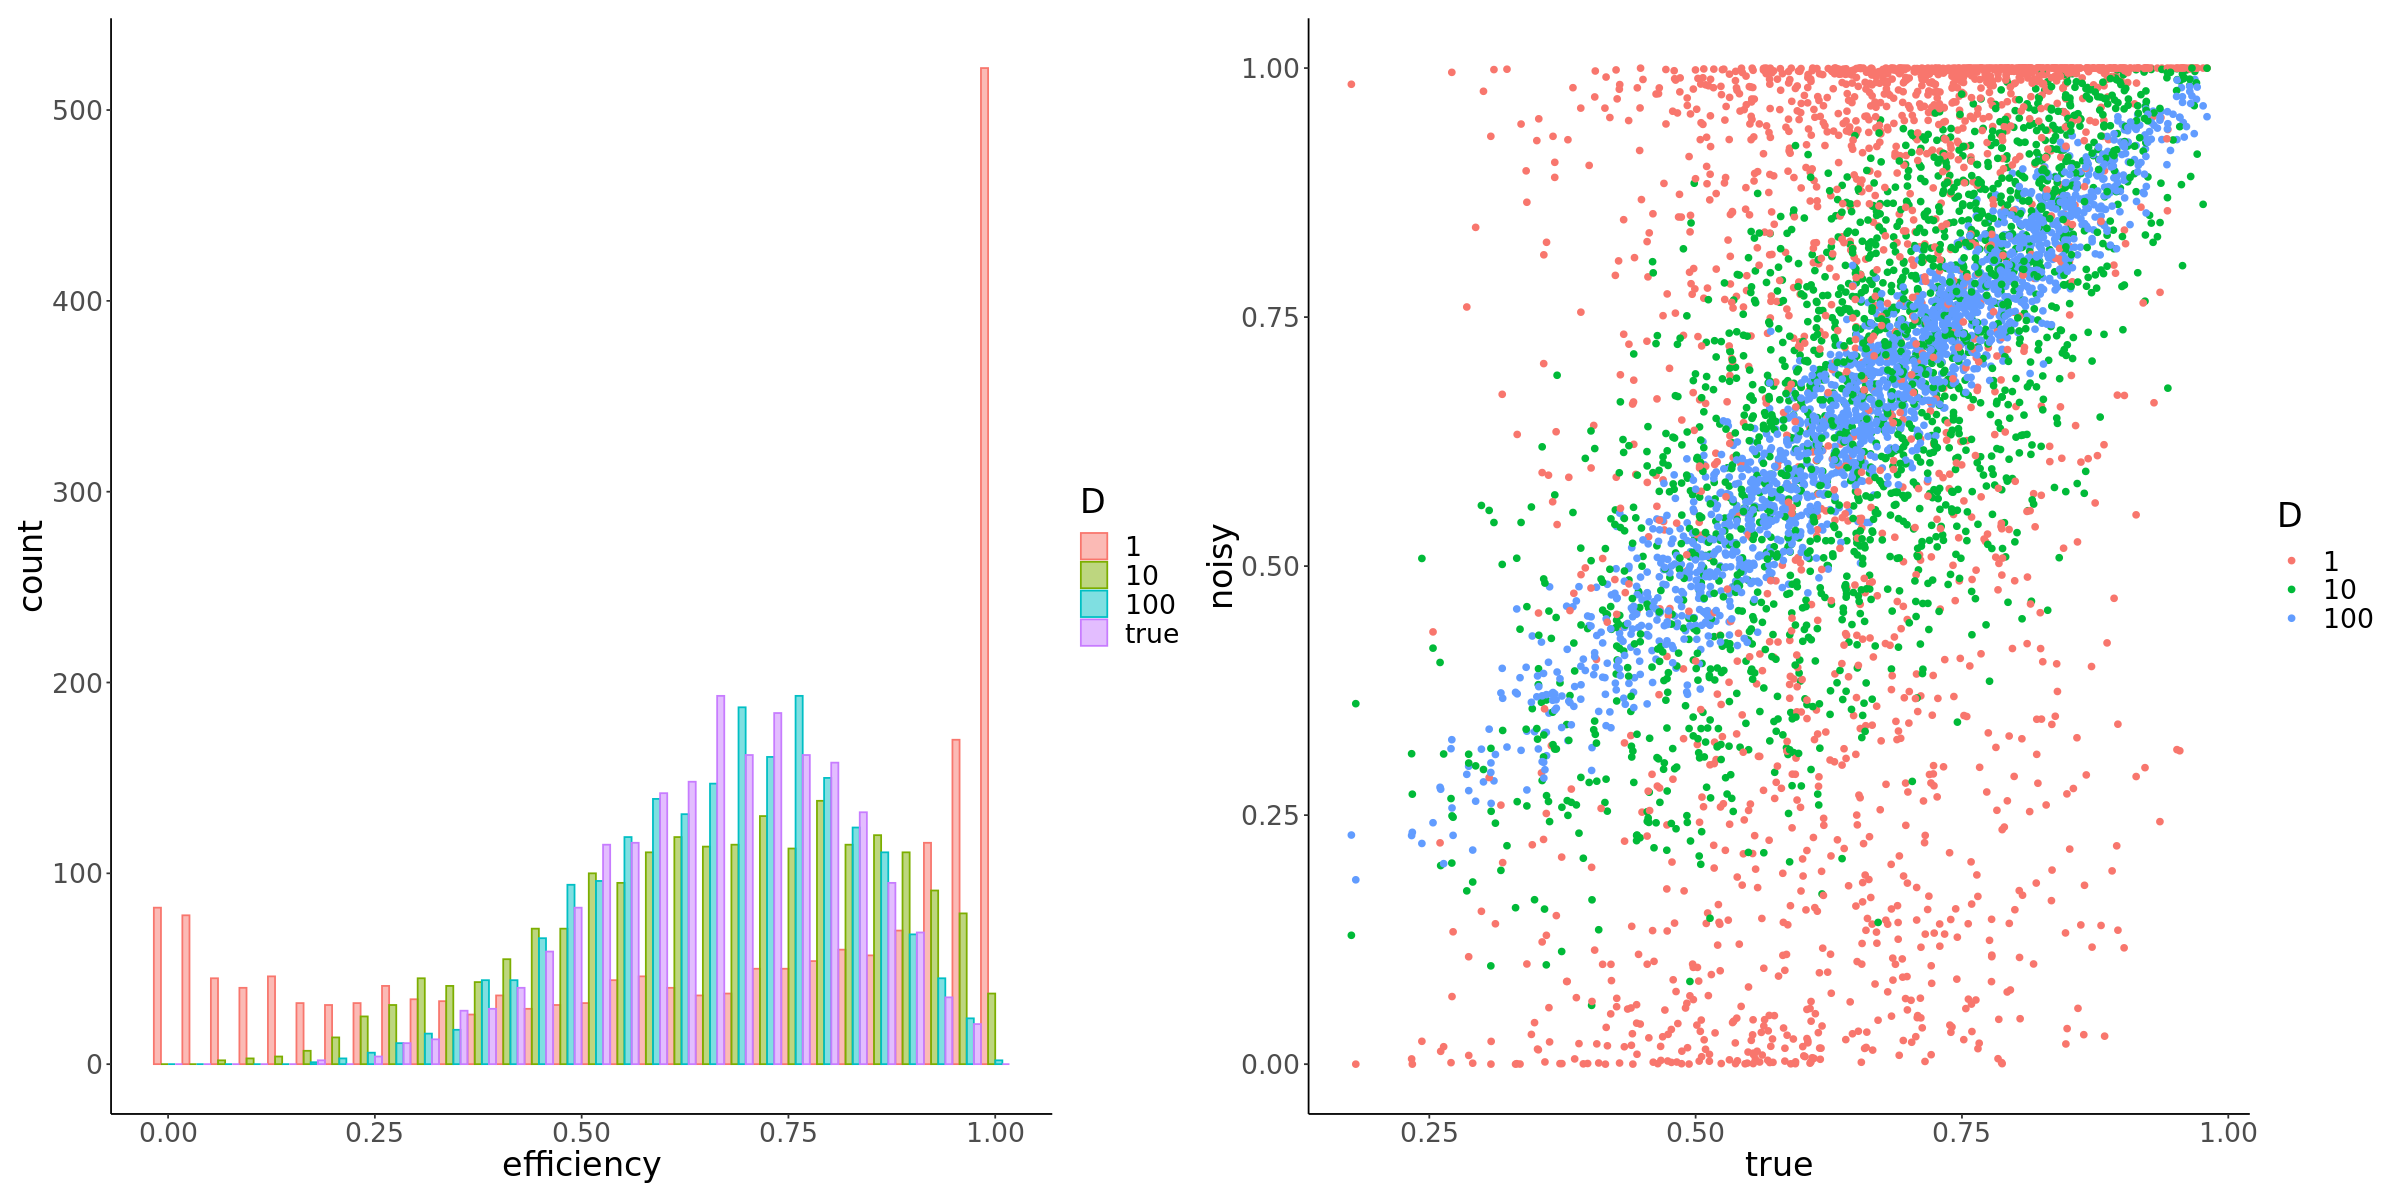

In [20]:
# make df for plotting histogram
noisy.hist.plotdf <- noisy.eff %>% pivot_longer(-guide, names_to = "D", values_to = "efficiency")

est.efficiencies.hist.p <- ggplot(noisy.hist.plotdf,
                                aes(x = efficiency, fill = D, color = D)) + 
                            geom_histogram(position = "dodge", alpha = 0.5) + 
                            theme_classic() + 
                            theme(text = element_text(size = 20)) 

# make df for scatterplot comparing true to noisy efficiencies
noisy.scatter.plotdf <- noisy.eff %>% pivot_longer(cols = !c(guide,true), names_to = "D", values_to = "noisy")

est.efficiencies.scatter.p <- ggplot(noisy.scatter.plotdf, aes(x = true, y = noisy, col = D)) + geom_point() +                         
                                        theme_classic() + 
                                        theme(text = element_text(size = 20)) 

est.efficiencies.hist.p | est.efficiencies.scatter.p

# Examine coefficients
These are the ground truth coefficients, which were used for calculating $\mu$ to define negative binomial distribution from which simulated counts were sampled.

In [ ]:
coeffs <- h5read(h5.path, "coeffs")

Plot 

In [ ]:
coeffs.plotdf <- coeffs %>% pivot_longer(cols = everything(), names_to = "coeff") %>%
                        mutate(coeff.symbol = recode(coeff,
                                    "beta0" = "{beta}[0]",
                                    "beta.enh" = "{beta}[enhancer]",
                                    "beta.s" = "{beta}[S]",
                                    "beta.g2m" = "{beta}[G2M]",
                                    "beta.mito" = "{beta}[mito]"
                                  ))

ggplot(coeffs.plotdf, aes(x = value)) + geom_histogram() + 
            facet_grid(~coeff.symbol, scales = "free_x", labeller = label_parsed) + 
            theme_classic() +
            theme(text = element_text(size=20)) 

# Examine variables
Values of $X_{perturb}, X_S, X_{G2M}, X_{mito}$ used with simulated coefficient values to calculate $\mu$ for simulating counts.

### $X_{perturb}$
Storied as a matrix with $ngenes$ rows and $ncells$ columns. Every cell has a unique value of $X_{perturb}$ for each gene that is a function of which, if any, gRNAs targeting enhancer(s) of the gene are found in the cell.

In [ ]:
# pull out values of X from h5
x.perturb <- h5read(h5.path, "x/perturbation_prob")

In [ ]:
# check dimensions of x.perturb
dim(x.perturb)

Let's pull out the values of $X_{perturb}$ for all the cells in experiment for a gene whose enhancer is targeted in this simulated experiment. We'll display a table that shows the observed perturbation probabilities across all cells and the number of cells that had each perturbation probability.

In [ ]:
target.gene <- sample(guide.metadata$target.gene, 1)
print(paste("Checking perturbation probability of enhancer of gene", target.gene))

In [ ]:
data.frame(table(x.perturb[target.gene,]))

### $X_S, X_{G2M}$

These are the cell cycle scores (S and G2M phase), let's take a look.

In [ ]:
cell.cycle.scores <- h5read(h5.path, "x/cell_cycle_scores")

Visualize cell cycle scores.

In [ ]:
cell.cycle.plotdf <- cell.cycle.scores %>% pivot_longer(cols = everything(), names_to = "cell.cycle", values_to = "score")

ggplot(cell.cycle.plotdf, aes(x = score)) + geom_histogram() + facet_wrap(~cell.cycle) +
            theme_classic() + theme(text = element_text(size = 20))

### $X_{mito}$

These are the simulated values for percentage of reads mapping to the mitochondrial genome in each cell.

In [11]:
pct.mito <- h5read(h5.path, "x/percent_mito")

Visualize

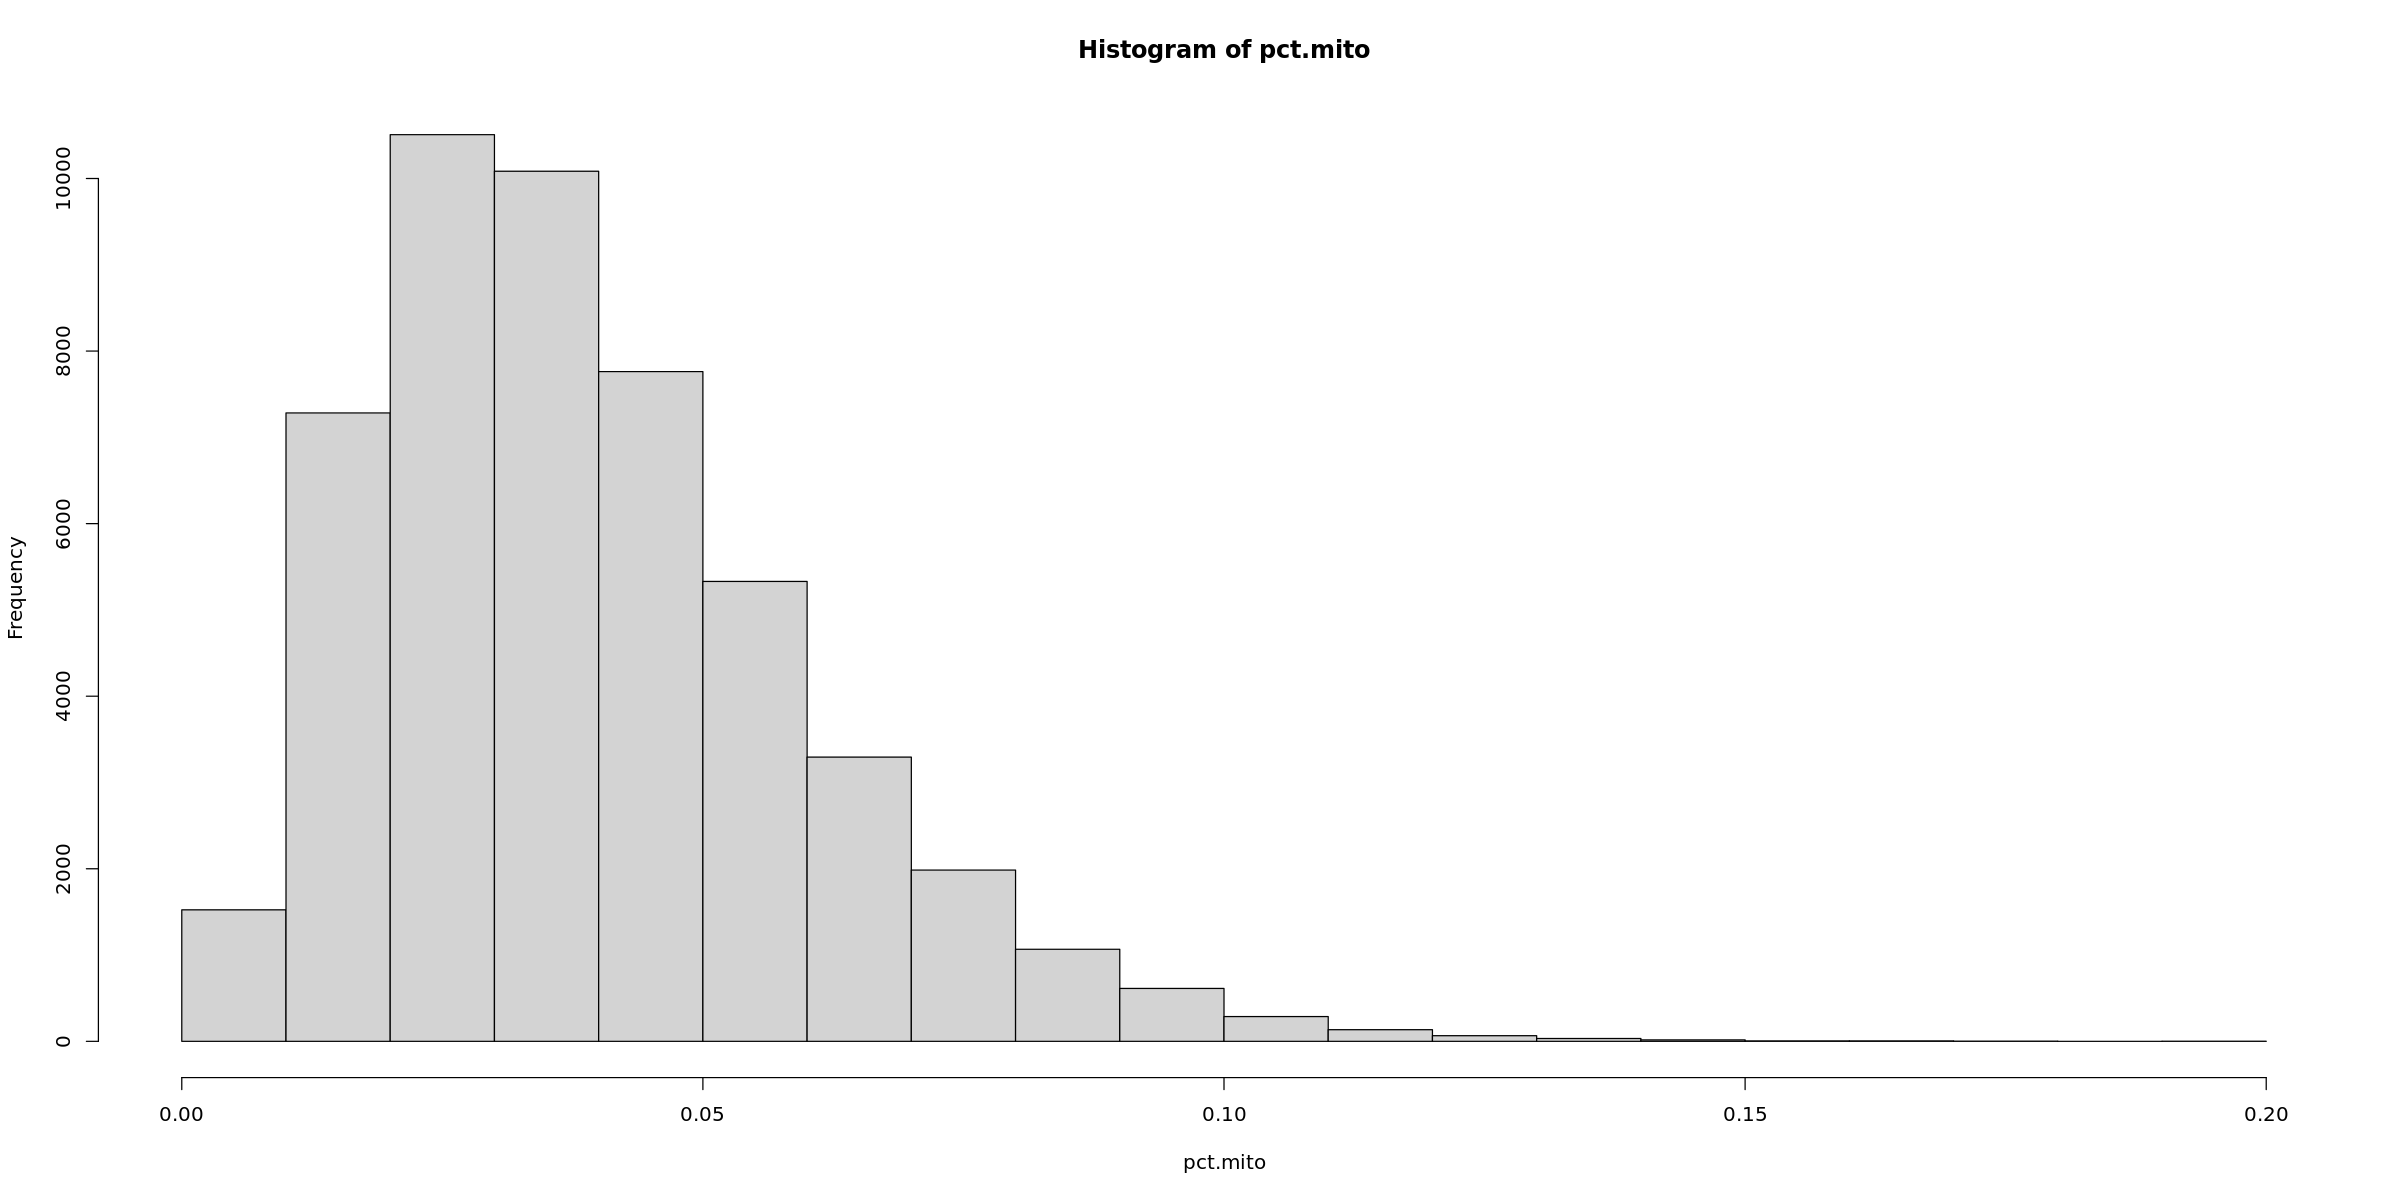

In [12]:
hist(pct.mito)

# Scaling factor

Additionally, we simulated total counts per cell by sampling from a Poisson distribution parameterized by $\lambda=50000$, which allowed us to calculate a scaling factor ($s$) for each cell by dividing the total counts by 1e6. We visualize the distribution of scaling factors here:

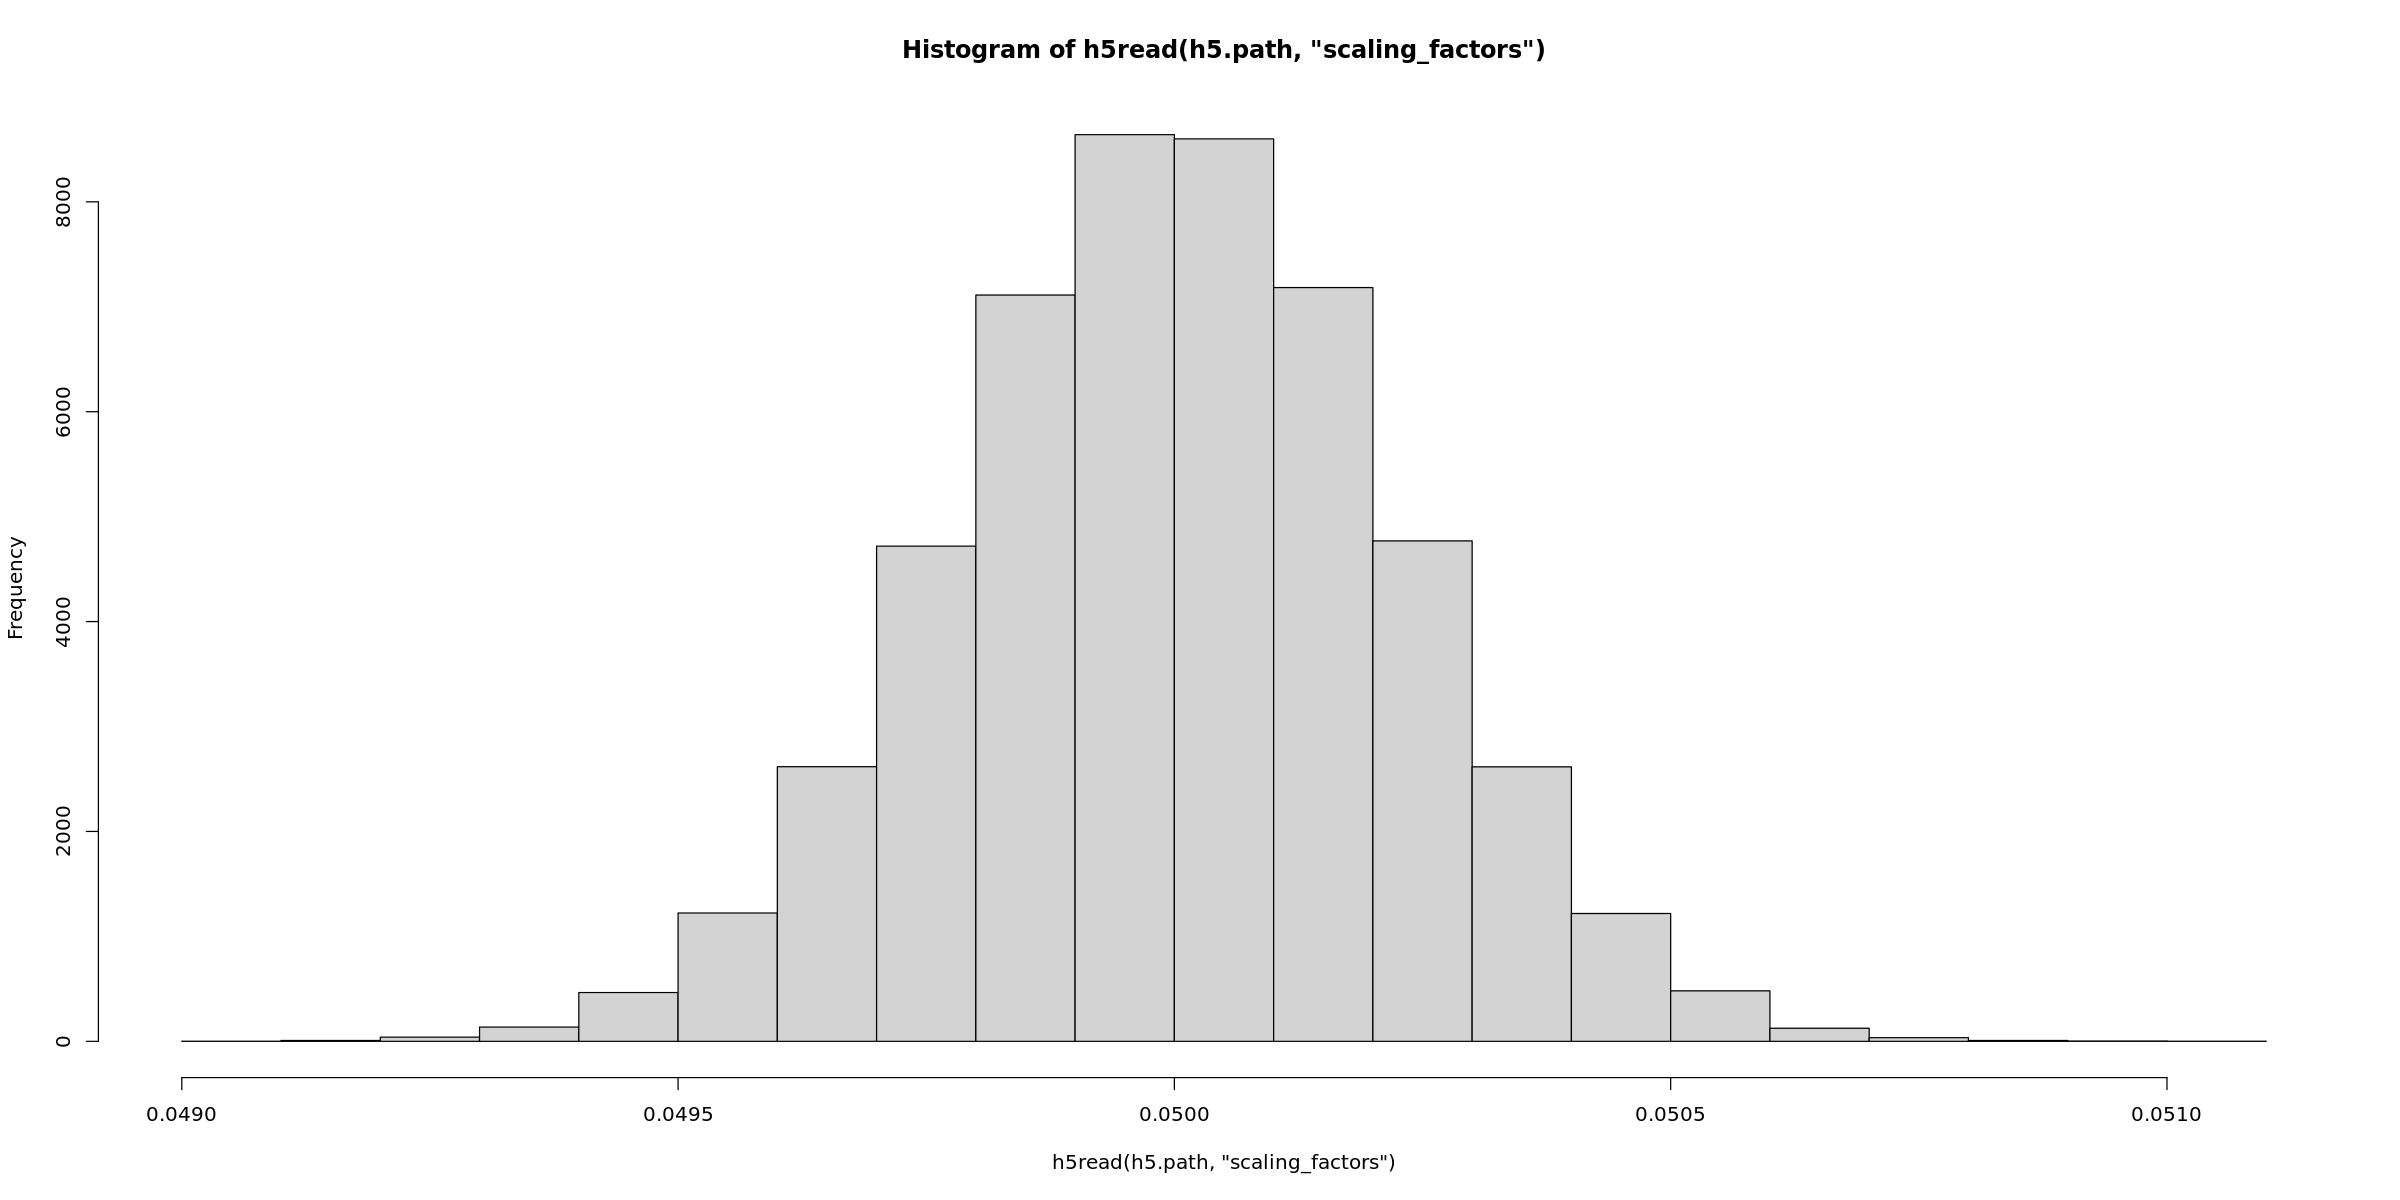

In [19]:
hist(h5read(h5.path, "scaling_factors"))

# Simulated counts
The simulated counts are stored as a matrix in the h5 file and can be retrieved like so:


In [13]:
counts <- h5read(h5.path, "counts/counts")

We can see that the number of rows corresponds to the number of genes in the simulated experiment, and the number of columns corresponds to the number of cells in the simulated experiment.

In [14]:
dim(counts)

[1] 13000 50000

Each row index corresponds to a gene identifier, and each column index corresponds to a cell identifier.

You can also retrieve a specific row from the counts matrix like so if you don't want to load the entire counts matrix into memory at once:

In [15]:
# pull out counts for all cells for a random gene in our dataset
obs.counts <- h5read(h5.path, name = "counts/counts", index = list(sample(1:13000, 1), 1:50000))

In [16]:
dim(obs.counts)

[1]     1 50000

# Other

We also wrote the values of the **linear predictor**:

$$
\beta_0 + \beta_{enhancer}X_{perturb} + \beta_S X_S + \beta_{G2M} X_{G2M} + \beta_{mito}X_{mito} + \log (s)
$$


associated with each gene in the simulated dataset. This might be useful for debugging or better understanding the data. They are stored in `linear_predictor/linear_predictor`.

In [17]:
lp <- h5read(h5.path, "linear_predictor/linear_predictor")

In [18]:
dim(lp)

[1] 13000 50000